Mounted at /content/drive


<ipython-input-1-27f1d5a18d60>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_df['genres'] = movies_df['genres'].astype(str).str.split(',')
<ipython-input-1-27f1d5a18d60>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_df['release_year'] = movies_df['release_date'].dt.year


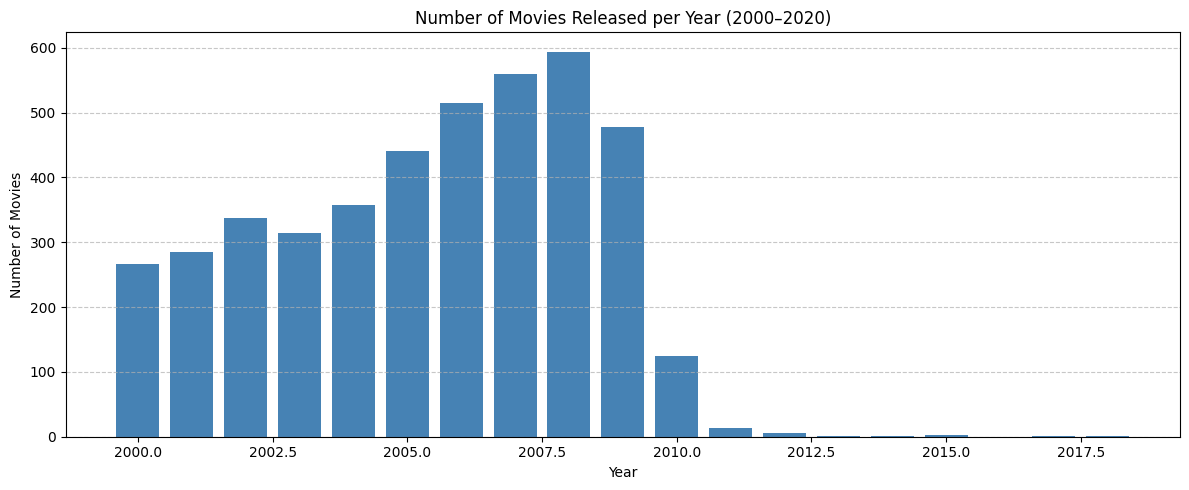

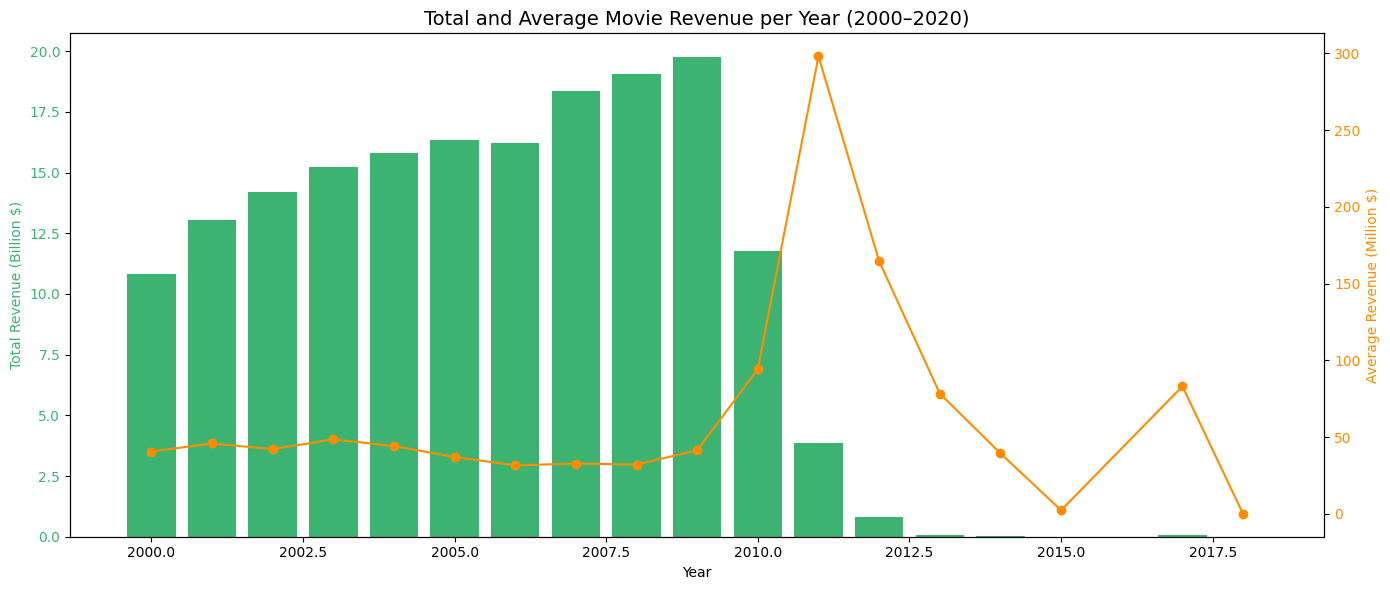

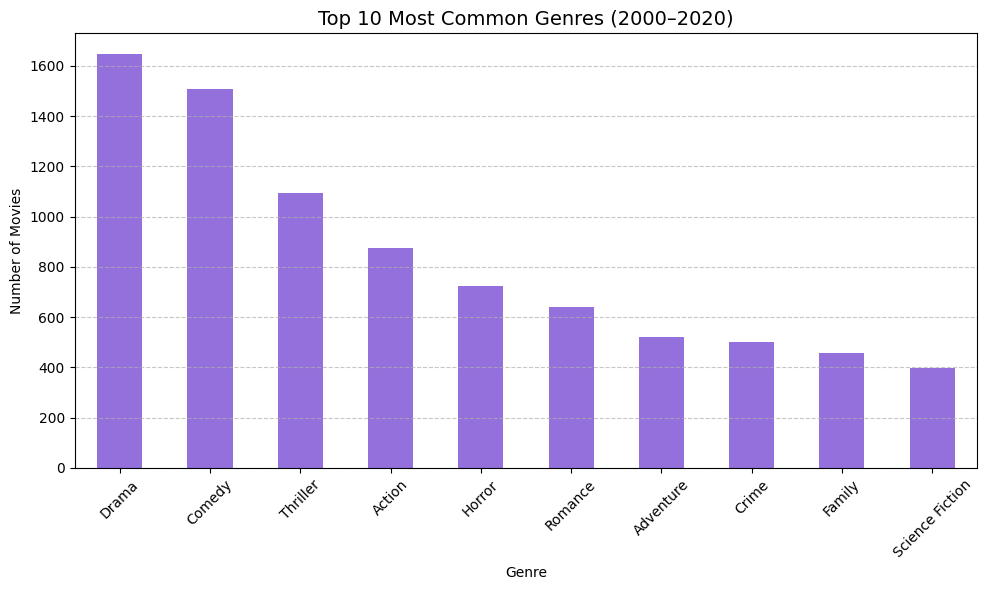

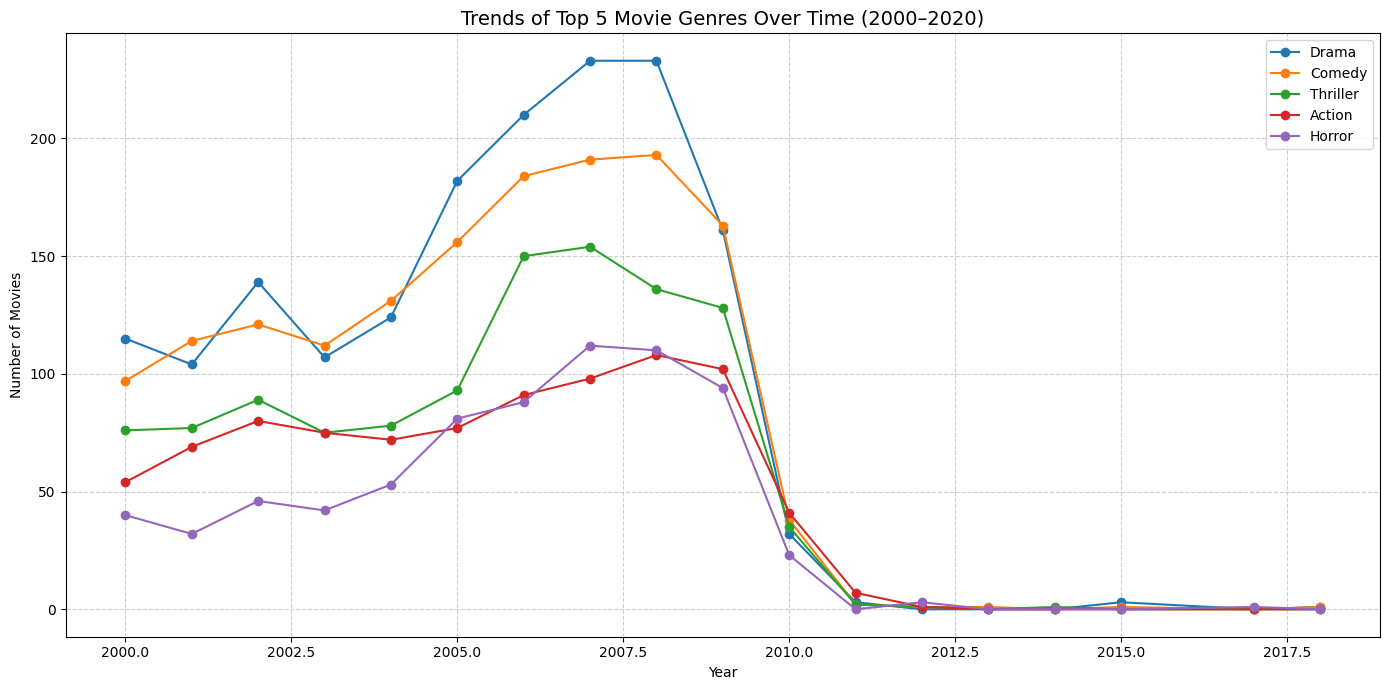

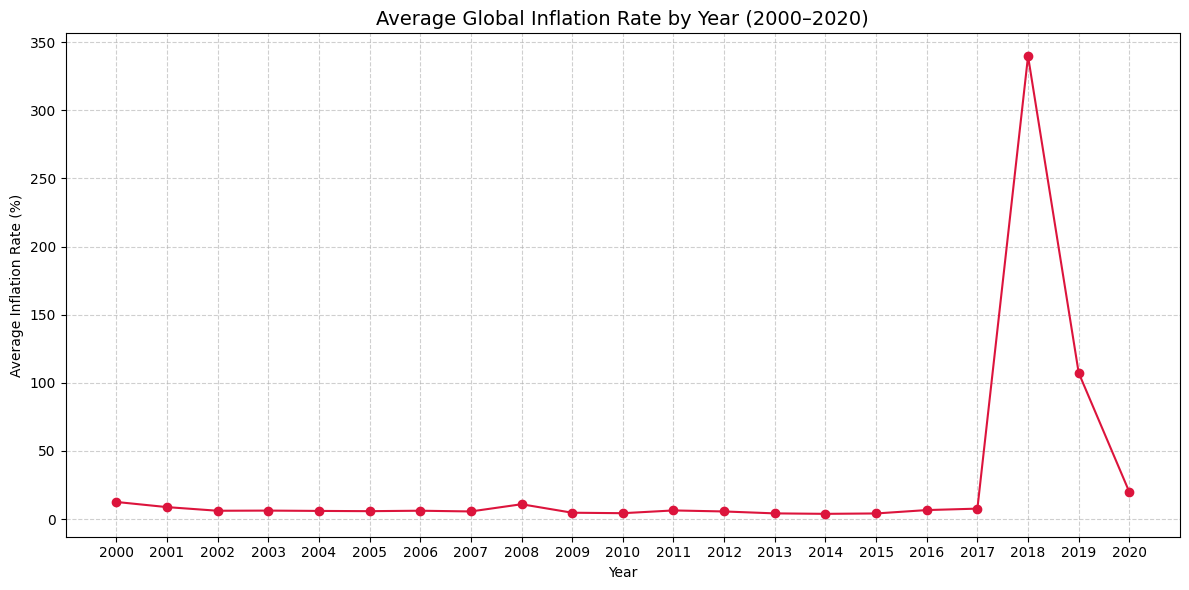

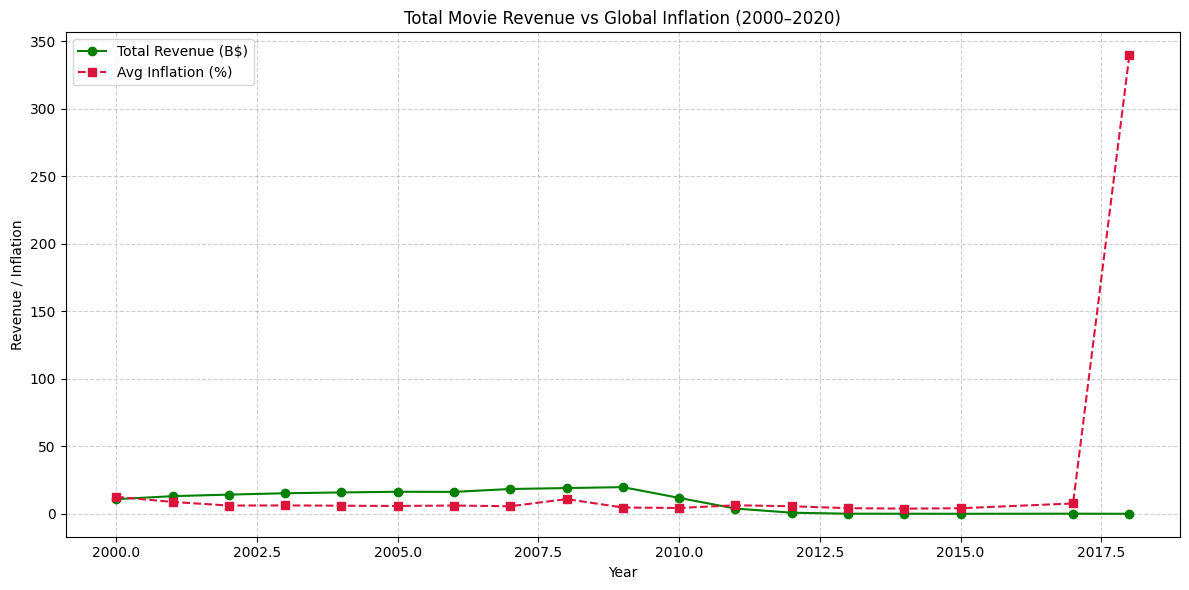

Correlation Between Global Inflation and Movie Counts by Genre (2000–2020):
      Genre  Correlation with Inflation
0    Horror                   -0.238357
1     Drama                   -0.245888
2  Thriller                   -0.256322
3    Comedy                   -0.258584
4    Action                   -0.279875


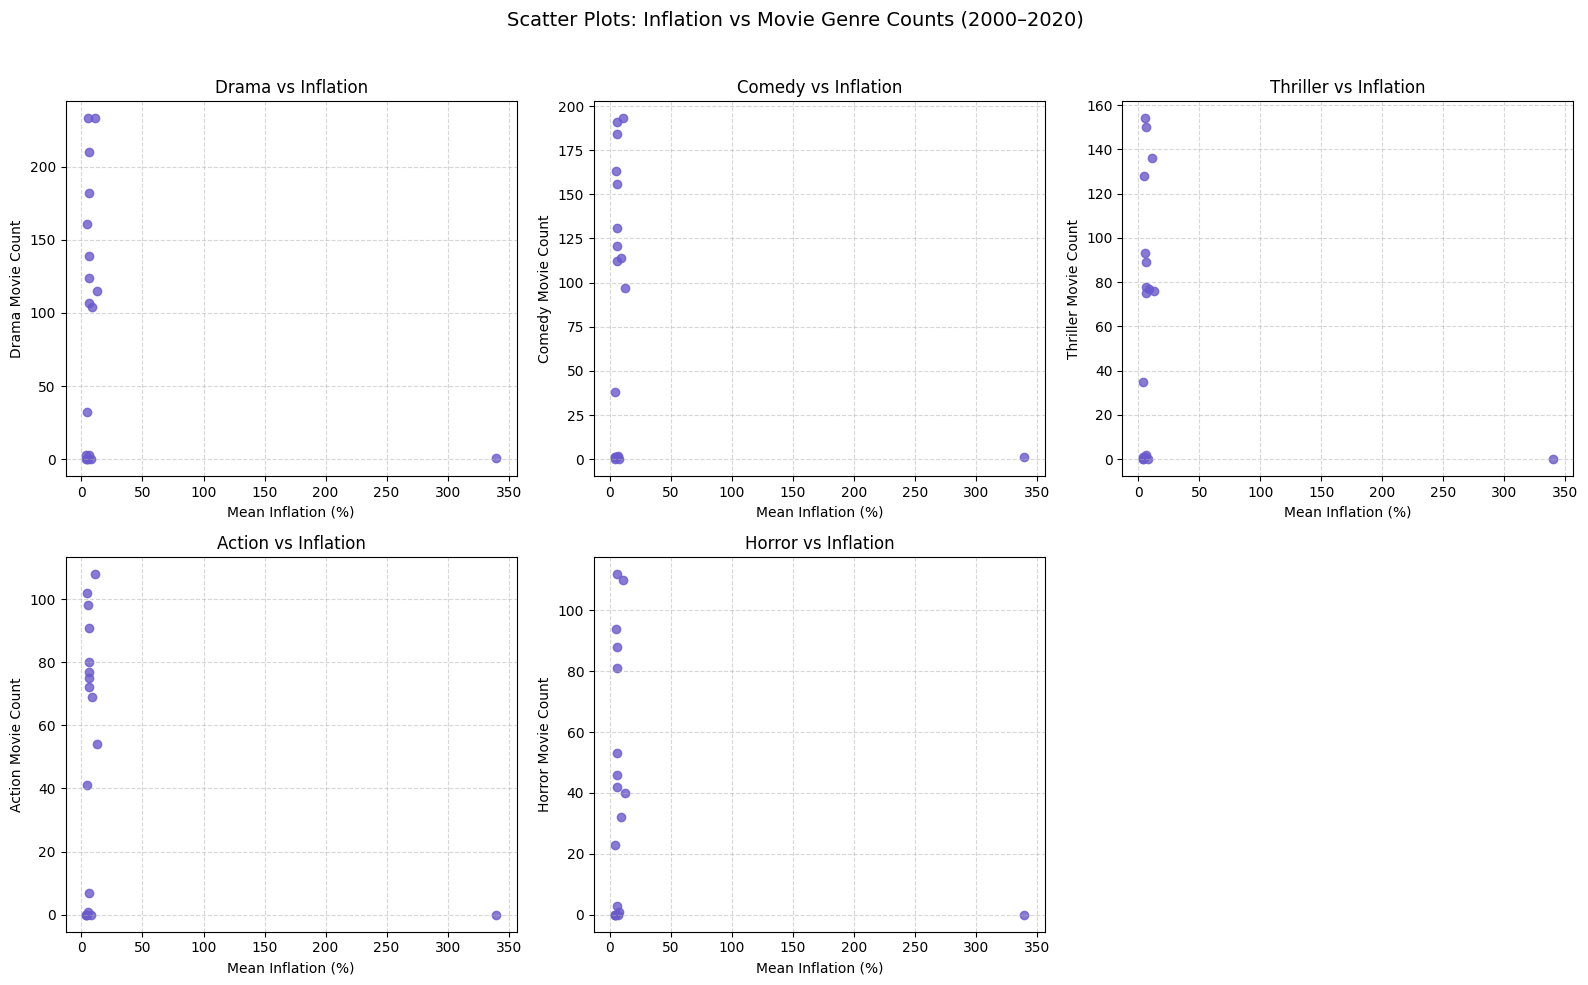

In [1]:
# Full EDA: Inflation vs Movie Revenues and Genres (2000–2020) – With All Graphs
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import matplotlib.pyplot as plt

# Load and Clean Data
movies_df = pd.read_csv('/content/drive/MyDrive/Movies.csv')
inflation_df = pd.read_csv('/content/drive/MyDrive/global_inflation_data.csv')

# Clean movie data
movies_df['release_date'] = pd.to_datetime(movies_df['release_date'], errors='coerce')
movies_df = movies_df.dropna(subset=['release_date', 'genres', 'revenue'])
movies_df['genres'] = movies_df['genres'].astype(str).str.split(',')
movies_df['release_year'] = movies_df['release_date'].dt.year
movies_df = movies_df[(movies_df['release_year'] >= 2000) & (movies_df['release_year'] <= 2020)]

# Explode genres
movies_exploded = movies_df.explode('genres')
movies_exploded['genres'] = movies_exploded['genres'].str.strip()

# Get top 5 genres
top_genres = movies_exploded['genres'].value_counts().head(5).index.tolist()

# Genre counts by year
genre_counts_by_year = (
    movies_exploded[movies_exploded['genres'].isin(top_genres)]
    .groupby(['release_year', 'genres'])
    .size()
    .unstack(fill_value=0)
    .reset_index())

# Data preperation for Inflation
inflation_df = inflation_df.loc[:, ['country_name'] + [str(year) for year in range(2000, 2021)]]
inflation_by_year = inflation_df.drop(columns=['country_name']).T
inflation_by_year.index.name = 'year'
inflation_by_year.columns = [f'country_{i}' for i in range(inflation_by_year.shape[1])]
inflation_by_year = inflation_by_year.reset_index()
inflation_by_year['year'] = inflation_by_year['year'].astype(int)
inflation_by_year['mean_inflation'] = inflation_by_year.iloc[:, 1:].apply(pd.to_numeric, errors='coerce').mean(axis=1)

# Revenue Analysis
revenue_per_year = movies_df.groupby('release_year')['revenue'].agg(['sum', 'mean']).reset_index()
revenue_per_year.rename(columns={'release_year': 'year', 'sum': 'total_revenue', 'mean': 'average_revenue'}, inplace=True)

# Merge Datasets
revenue_inflation_df = pd.merge(revenue_per_year, inflation_by_year[['year', 'mean_inflation']], on='year')
genre_inflation_df = pd.merge(genre_counts_by_year, inflation_by_year[['year', 'mean_inflation']],
                              left_on='release_year', right_on='year').drop(columns='year')

# Find Correlation
correlation_data = genre_inflation_df[top_genres + ['mean_inflation']]
correlation_matrix = correlation_data.corr()
inflation_vs_genres = correlation_matrix.loc['mean_inflation', top_genres].sort_values(ascending=False)
inflation_vs_genres_df = inflation_vs_genres.reset_index()
inflation_vs_genres_df.columns = ['Genre', 'Correlation with Inflation']

# Graphs

# 1. Number of Movies Released Per Year
plt.figure(figsize=(12, 5))
plt.bar(movies_df['release_year'].value_counts().sort_index().index,
        movies_df['release_year'].value_counts().sort_index().values,
        color='steelblue')
plt.title('Number of Movies Released per Year (2000–2020)')
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 2. Total and Average Revenue Per Year
fig, ax1 = plt.subplots(figsize=(14, 6))
ax1.bar(revenue_per_year['year'], revenue_per_year['total_revenue'] / 1e9, color='mediumseagreen', label='Total Revenue (B$)')
ax1.set_ylabel('Total Revenue (Billion $)', color='mediumseagreen')
ax1.set_xlabel('Year')
ax1.tick_params(axis='y', labelcolor='mediumseagreen')
ax2 = ax1.twinx()
ax2.plot(revenue_per_year['year'], revenue_per_year['average_revenue'] / 1e6, color='darkorange', marker='o', label='Avg Revenue (M$)')
ax2.set_ylabel('Average Revenue (Million $)', color='darkorange')
ax2.tick_params(axis='y', labelcolor='darkorange')
plt.title('Total and Average Movie Revenue per Year (2000–2020)', fontsize=14)
fig.tight_layout()
plt.show()

# 3. Most Common Genres
genre_counts = movies_exploded['genres'].value_counts()
plt.figure(figsize=(10, 6))
genre_counts.head(10).plot(kind='bar', color='mediumpurple')
plt.title('Top 10 Most Common Genres (2000–2020)', fontsize=14)
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 4. Genre Trends Over Time
genre_trend = movies_exploded.groupby(['release_year', 'genres']).size().unstack(fill_value=0)
genre_trend_top = genre_trend[top_genres]
plt.figure(figsize=(14, 7))
for genre in top_genres:
    plt.plot(genre_trend_top.index, genre_trend_top[genre], marker='o', label=genre)
plt.title('Trends of Top 5 Movie Genres Over Time (2000–2020)', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# 5. Average Global Inflation Rate by Year
plt.figure(figsize=(12, 6))
plt.plot(inflation_by_year['year'], inflation_by_year['mean_inflation'], marker='o', color='crimson')
plt.title('Average Global Inflation Rate by Year (2000–2020)', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Average Inflation Rate (%)')
plt.xticks(inflation_by_year['year'])
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# 6. Revenue vs Inflation (Line)
plt.figure(figsize=(12, 6))
plt.plot(revenue_inflation_df['year'], revenue_inflation_df['total_revenue'] / 1e9, label='Total Revenue (B$)', color='green', marker='o')
plt.plot(revenue_inflation_df['year'], revenue_inflation_df['mean_inflation'], label='Avg Inflation (%)', color='crimson', linestyle='--', marker='s')
plt.title('Total Movie Revenue vs Global Inflation (2000–2020)')
plt.xlabel('Year')
plt.ylabel('Revenue / Inflation')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# 7. Correlation Table
print("Correlation Between Global Inflation and Movie Counts by Genre (2000–2020):")
print(inflation_vs_genres_df)

# 8. Scatter Plots: Inflation vs Each Genre
plt.figure(figsize=(16, 10))
for i, genre in enumerate(top_genres):
    plt.subplot(2, 3, i+1)
    plt.scatter(genre_inflation_df['mean_inflation'], genre_inflation_df[genre], alpha=0.8, color='slateblue')
    plt.title(f'{genre} vs Inflation')
    plt.xlabel('Mean Inflation (%)')
    plt.ylabel(f'{genre} Movie Count')
    plt.grid(True, linestyle='--', alpha=0.5)
plt.suptitle('Scatter Plots: Inflation vs Movie Genre Counts (2000–2020)', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
